In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))

import copy
import glob
import typing

from IPython.display import display, Markdown

from collections import defaultdict
import numpy as np
import pandas as pd
from pandas.core.groupby import SeriesGroupBy  # type: ignore
import scipy
from scipy import stats

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.axes
import matplotlib.patches
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec

from simple_relational_reasoning.embeddings.visualizations import DEFAULT_COLORMAP, DEFAULT_BAR_KWARGS, DEFAULT_TEXT_KWARGS, DEFAULT_YLIM, plot_prettify, filter_and_group, save_plot  # type: ignore


In [34]:
USE_LARGER_RESUTLS = False

IGNORE_SMALLER_LIST = ('baseline.csv', 'dino.csv', 'flipping.csv')
IGNORE_LARGER_LIST = ('baseline_larger_dataset.csv', 'dino_larger_dataset.csv', 'flipping_larger_dataset.csv')
CORRECT_KEY = 'containment_high_containment_cos'
INCORRECT_KEYS = ['containment_behind_cos', 'containment_support_cos']
ORDERED_COLUMNS = ['model', 'training', 'flip', 'dino', 'configuration_index', 'example_index', 'bowl_color', 'target_object', 
        'containment_high_containment_cos', 'containment_behind_cos', 'containment_support_cos',
        'high_containment_behind_cos', 'high_containment_support_cos', 'behind_support_cos', 
        'correct', 'cos_ratio', 'cos_diff']
TARGET_OBJECTS = ['BeachBall', 'Knight', 'Lego', 'Pineapple', 'Robot', 'RubberDuck', 'Teddy', 'Truck']


def load_and_join_dataframes(folder: str, ext: str = '.csv', ignore_list: typing.Sequence[str] = tuple()) -> pd.DataFrame:
    files = glob.glob(os.path.join(folder, '*' + ext))
    df = pd.concat([pd.read_csv(f) for f in files if os.path.basename(f) not in ignore_list])
    df.reset_index(drop=True, inplace=True)
    return df


def parse_model_name(df: pd.DataFrame) -> pd.DataFrame:
    new_series_values = defaultdict(list)

    for name in df.model:
        split_index = name.index('-')
        base_model, training_type = name[:split_index], name[split_index + 1:]

        flip = None
        dino = None

        if 'DINO' in training_type:
            training_type, dino = training_type.split('-')
            if dino == 'S':
                dino = 'saycam(S)'

        if '-' in training_type:
            training_type, flip = training_type.split('-')
            training_type += '-flip'

        if training_type == 'imagenet':
            training_type = 'ImageNet'

        new_series_values['model'].append(base_model)
        new_series_values['training'].append(training_type)
        new_series_values['flip'].append(flip)
        new_series_values['dino'].append(dino)

    return df.assign(**new_series_values)


# def add_target_object_field(df: pd.DataFrame) -> pd.DataFrame:
#     return df.assign(target_object=[TARGET_OBJECTS[i % len(TARGET_OBJECTS)] for i in df.image_index])


def evaluate_accuracy(df: pd.DataFrame, correct_key: str = CORRECT_KEY, 
    incorrect_keys: typing.Sequence[str] = INCORRECT_KEYS) -> pd.DataFrame:
    correct = []
    cos_ratio = []
    cos_diff = []

    for _, row in df.iterrows():    
        correct_val = row[correct_key]
        max_incorrect_val = max([row[k] for k in incorrect_keys])  # type: ignore

        correct.append(correct_val >= max_incorrect_val)
        cos_ratio.append(correct_val / max_incorrect_val)
        cos_diff.append(correct_val - max_incorrect_val)

    return df.assign(correct=correct, cos_ratio=cos_ratio, cos_diff=cos_diff)


def full_load_pipeline(folder: str, ignore_list: typing.Sequence[str] = tuple()):
    df = load_and_join_dataframes(folder, ignore_list=ignore_list)
    df.drop(columns=[df.columns[0]], inplace=True)  # type: ignore
    df = parse_model_name(df)
    # df = add_target_object_field(df)
    df = evaluate_accuracy(df)
    df = df[ORDERED_COLUMNS]
    return df


larger_df = full_load_pipeline('../containment_support_outputs', ignore_list=IGNORE_SMALLER_LIST)
smaller_df = full_load_pipeline('../containment_support_outputs', ignore_list=IGNORE_LARGER_LIST)
print(larger_df.shape, smaller_df.shape)

if USE_LARGER_RESUTLS:
    combined_df = larger_df
else:
    combined_df = smaller_df


print(combined_df.shape)
combined_df.head()

(98304, 17) (12288, 17)
(12288, 17)


,model,training,flip,dino,configuration_index,example_index,bowl_color,target_object,containment_high_containment_cos,containment_behind_cos,containment_support_cos,high_containment_behind_cos,high_containment_support_cos,behind_support_cos,correct,cos_ratio,cos_diff
0,resnext,saycam(S)-flip,s,None,0,0,brown,BeachBall,0.821403,0.827495,0.846809,0.928499,0.909522,0.974116,False,0.969998,-0.025406
1,resnext,saycam(S)-flip,s,None,0,1,brown,Knight,0.856041,0.829619,0.841452,0.944829,0.912327,0.954147,True,1.017338,0.014589
2,resnext,saycam(S)-flip,s,None,0,2,brown,Lego,0.838563,0.838034,0.814633,0.952457,0.899645,0.939837,True,1.000631,0.000529
3,resnext,saycam(S)-flip,s,None,0,3,brown,Pineapple,0.817329,0.808149,0.797166,0.935150,0.886878,0.955024,True,1.011358,0.009179
4,resnext,saycam(S)-flip,s,None,0,4,brown,Robot,0.828670,0.791044,0.763196,0.904463,0.852929,0.949094,True,1.047565,0.037626


In [4]:
DEFAULT_ORDERS = {
    'model_name': ['mobilenet', 'resnext'],
    'training': ['saycam(S)', 'ImageNet', 'random'],
    'above_below_type': ['one_reference', 'adjacent_references', 'gapped_references'],
    'flip': ['s', 'h', 'v', 'hv'],
    'triplet_generator': ['diagonal', 'equidistant'],
    'same_horizontal_half': [True, False],
    'condition': ['different_shapes', 'split_text', 'random_color'],
}

# nested dict, where the first key is the style (name, hatch, etc,)
# the second key is the field name (model name, relation, etc)
# the third key is the field value (resnext, mobilenet, etc.)
# and the value is the value for that style keyword
DEFAULT_PLOT_STYLES = dict(
    color=dict(
        # if we color by model
        model={
            'mobilenet': DEFAULT_COLORMAP(0),
            'resnext': DEFAULT_COLORMAP(1),
        },
        # if we color by dino
        dino={
            'ImageNet': DEFAULT_COLORMAP(2), 
            'saycam(S)': DEFAULT_COLORMAP(3),
        },
        # if we color by flip
        flip={
            's': DEFAULT_COLORMAP(4),
            'h': DEFAULT_COLORMAP(5),
            'v': DEFAULT_COLORMAP(6),
            'hv': DEFAULT_COLORMAP(7),
        }
    ),
    hatch=dict(
        n_target_types={
            1: '',
            2: '/',
        },
        n_habituation_stimuli={
            1: '',
            4: '+',
        }
    )
)

DEFAULT_SUBPLOT_ADJUST_PARAMS = dict(top=0.8)

DEFAULT_LINE_KWARGS = dict(marker='.', linestyle='-')

DEFAULT_YALBELS = defaultdict(lambda: 'Accuracy', 
    cos_ratio='Cosine similarity ratio',
    cos_diff='Cosine similarity difference',
)


def plot_single_bar(
    ax: matplotlib.axes.Axes,
    x: float,
    key: typing.Sequence[str],
    mean: pd.core.groupby.SeriesGroupBy,  # type: ignore
    std: pd.core.groupby.SeriesGroupBy,   # type: ignore
    plot_std: bool,
    bar_width: float, 
    bar_kwargs: typing.Dict[str, typing.Any],
    global_bar_kwargs: typing.Dict[str, typing.Union[str, int]],
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
):

    key = tuple(key)
    m = mean.loc[key]

    if remap_range is not None:
        m = m * (remap_range[1] - remap_range[0]) + remap_range[0]

    if plot_std:
        s = std.loc[key]
    else:
        s = None

    ax.bar(x, m, yerr=s, width=bar_width, **bar_kwargs, **global_bar_kwargs) 
    # TODO: above bar texts would go here, if they exist
    return x + bar_width 


def plot_single_panel(
    ax: matplotlib.axes.Axes,
    mean: SeriesGroupBy,
    std: SeriesGroupBy,
    plot_std: bool,
    orders_by_field: typing.Dict[str, typing.List[str]],
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]],
    group_bars_by: str, 
    color_bars_by: str, 
    hatch_bars_by: typing.Optional[str] = None,
    bar_width: float = 0.2, 
    bar_group_spacing: float = 0.5, 
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
    add_chance_hline: bool = True,
    y_chance: float = 0.5,
    global_bar_kwargs: typing.Dict[str, typing.Union[str, int]] = DEFAULT_BAR_KWARGS,
    text_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    ylim: typing.Tuple[float, float] = DEFAULT_YLIM,
    ylabel: str = 'Accuracy', 
):
    x = 0

    for group_by_value in orders_by_field[group_bars_by]:
        for color_by_value in orders_by_field[color_bars_by]:
            bar_kwargs = dict(facecolor=plot_style_by_field['color'][color_bars_by][color_by_value])

            group_and_color_key = [group_by_value, color_by_value]

            if hatch_bars_by is not None:
                for hatch_by_value in orders_by_field[hatch_bars_by]:
                    bar_kwargs['hatch'] = plot_style_by_field['hatch'][hatch_bars_by][hatch_by_value]

                    hatch_key = group_and_color_key[:]
                    hatch_key.append(hatch_by_value)

                    x = plot_single_bar(ax, x, hatch_key, mean, std, 
                        plot_std, bar_width, 
                        bar_kwargs, global_bar_kwargs,
                        remap_range=remap_range)
            
            else:
                x = plot_single_bar(ax, x, group_and_color_key, mean, std, 
                    plot_std, bar_width, 
                    bar_kwargs, global_bar_kwargs,
                    remap_range=remap_range)

        x += bar_group_spacing

    group_values = orders_by_field[group_bars_by]

    group_length = len(orders_by_field[color_bars_by]) * (len(orders_by_field[hatch_bars_by]) if hatch_bars_by is not None else 1)
    x_tick_locations = np.arange(len(group_values)) * (bar_group_spacing + bar_width * group_length) +\
                        bar_width * (group_length / 2 - 0.5)
    xtick_text_kwargs = text_kwargs.copy()
    if len(group_values) > 4:
        xtick_text_kwargs['fontsize'] -= 4
    ax.set_xticks(x_tick_locations)
    ax.set_xticklabels([plot_prettify(val, field_name=group_bars_by) for val in group_values], fontdict=xtick_text_kwargs)
    ax.tick_params(axis='both', which='major', labelsize=text_kwargs['fontsize'] - 4)

    if add_chance_hline:
        xlim = ax.get_xlim()
        if remap_range is not None:
            y_chance = (remap_range[1] - remap_range[0]) * y_chance + remap_range[0]
        ax.hlines(y_chance, *xlim, linestyle='--', alpha=0.5, color='black')
        ax.set_xlim(*xlim)
        
    if ylim is not None:
        if remap_range is not None:
            ylim = (ylim[0] * (remap_range[1] - remap_range[0]) + remap_range[0], ylim[1] * (remap_range[1] - remap_range[0]) + remap_range[0])
        ax.set_ylim(*ylim)

    ax.set_xlabel(plot_prettify(group_bars_by), **text_kwargs)
    _add_ylabel_to_ax(ax, ylabel, text_kwargs)


def line_plot_single_panel(
    ax: matplotlib.axes.Axes,
    mean: SeriesGroupBy,
    std: SeriesGroupBy,
    plot_std: bool,
    orders_by_field: typing.Dict[str, typing.List[str]],
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]],
    group_bars_by: str, 
    color_bars_by: str, 
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
    add_chance_hline: bool = True,
    y_chance: float = 0.5,
    global_line_kwargs: typing.Dict[str, typing.Any] = DEFAULT_LINE_KWARGS,
    text_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    ylim: typing.Tuple[float, float] = DEFAULT_YLIM,
    ylabel: str = 'Accuracy', 
):

    group_values = orders_by_field[group_bars_by]    
    x_locs = np.arange(len(group_values))
    for color_by_value in orders_by_field[color_bars_by]:
        means = [mean.loc[tuple([group_by_value, color_by_value])] for group_by_value in group_values]
        stds = [std.loc[tuple([group_by_value, color_by_value])] for group_by_value in group_values]

        if remap_range is not None:
            means = [m * (remap_range[1] - remap_range[0]) + remap_range[0] for m in means]

        if plot_std:
            ax.errorbar(x_locs, means, stds, color=plot_style_by_field['color'][color_bars_by][color_by_value],
                **global_line_kwargs)
        else:
            ax.plot(x_locs, means, color=plot_style_by_field['color'][color_bars_by][color_by_value],
                **global_line_kwargs)
    
    xtick_text_kwargs = text_kwargs.copy()
    if len(group_values) > 4:
        xtick_text_kwargs['fontsize'] -= 4
    ax.set_xticks(x_locs)
    ax.set_xticklabels([plot_prettify(val, field_name=group_bars_by) for val in group_values], fontdict=xtick_text_kwargs)
    ax.tick_params(axis='both', which='major', labelsize=text_kwargs['fontsize'] - 4)

    if add_chance_hline:
        xlim = ax.get_xlim()
        if remap_range is not None:
            y_chance = (remap_range[1] - remap_range[0]) * y_chance + remap_range[0]
        ax.hlines(y_chance, *xlim, linestyle='--', alpha=0.5, color='black')
        ax.set_xlim(*xlim)
        
    if ylim is not None:
        if remap_range is not None:
            ylim = (ylim[0] * (remap_range[1] - remap_range[0]) + remap_range[0], ylim[1] * (remap_range[1] - remap_range[0]) + remap_range[0])
        ax.set_ylim(*ylim)

    ax.set_xlabel(plot_prettify(group_bars_by), **text_kwargs)
    _add_ylabel_to_ax(ax, ylabel, text_kwargs)


def _add_ylabel_to_ax(ax: matplotlib.axes.Axes, ylabel: typing.Union[str, typing.Sequence[typing.Dict[str, typing.Any]]], 
    text_kwargs: typing.Dict[str, typing.Any]):

    if isinstance(ylabel, str):
        ax.set_ylabel(ylabel, **text_kwargs)

    elif isinstance(ylabel, (list, tuple)):
        multiple_label_kwargs = copy.copy(text_kwargs)
        multiple_label_kwargs['fontsize'] -= 4

        for ylabel_part in ylabel:
            ax.text(**ylabel_part, transform=ax.transAxes, **multiple_label_kwargs)

    else:
        print(f'Unrecognized ylabel: {ylabel}')


def add_legend_to_ax(ax: matplotlib.axes.Axes, 
    orders_by_field: typing.Dict[str, typing.List[str]],
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]],
    color_bars_by: str,
    hatch_bars_by: typing.Optional[str] = None,
    text_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    legend_loc: typing.Optional[str] = 'best', 
    legend_ncol: typing.Optional[int] = None,
    legend_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None):

    patches = []

    if legend_ncol is None:
        legend_ncol = 1

    if legend_kwargs is None:
        legend_kwargs = {}

    for color_by_value in orders_by_field[color_bars_by]:
        bar_kwargs = dict(facecolor=plot_style_by_field['color'][color_bars_by][color_by_value])
        patch_kwargs = dict(facecolor='none', edgecolor='black')
        patch_kwargs.update(bar_kwargs)
        patches.append(matplotlib.patches.Patch(**patch_kwargs, label=plot_prettify(color_by_value, color_bars_by)))
    
    if hatch_bars_by is not None:
        for hatch_by_value in orders_by_field[hatch_bars_by]:
            bar_kwargs=dict(hatch=plot_style_by_field['hatch'][hatch_bars_by][hatch_by_value])
            patch_kwargs = dict(facecolor='none', edgecolor='black')
            patch_kwargs.update(bar_kwargs)
            patches.append(matplotlib.patches.Patch(**patch_kwargs, label=plot_prettify(hatch_by_value, hatch_bars_by)))

    if len(patches) > 0: 
        ax.legend(handles=patches, loc=legend_loc, ncol=legend_ncol, 
            fontsize=text_kwargs['fontsize'] - 4, **legend_kwargs)
    

def multiple_bar_plots(df: pd.DataFrame, *,
    # what and how to plot arguments
    filter_dict: typing.Dict[str, typing.Union[str, None, typing.Sequence[str]]],
    group_bars_by: str, 
    color_bars_by: str, 
    panel_by: typing.Optional[str] = None, 
    hatch_bars_by: typing.Optional[str] = None,
    plot_field: str = 'acc_mean',
    compute_std: bool = False,
    plot_std: bool = True,
    sem: bool = True,
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
    orders_by_field: typing.Dict[str, typing.List[str]] = DEFAULT_ORDERS,
    # plot style arguments
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]] = DEFAULT_PLOT_STYLES, # type: ignore
    ax: typing.Union[matplotlib.axes.Axes, typing.Sequence[matplotlib.axes.Axes], None] = None,
    figsize: typing.Optional[typing.Tuple[float, float]] = None,
    layout: typing.Optional[typing.Tuple[int, int]] = None,
    bar_width: float = 0.2, 
    bar_group_spacing: float = 0.5, 
    add_chance_hline: bool = True,
    y_chance: float = 0.5,
    global_bar_kwargs: typing.Dict[str, typing.Any] = DEFAULT_BAR_KWARGS,
    global_line_kwargs: typing.Dict[str, typing.Any] = DEFAULT_LINE_KWARGS,
    text_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    title_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    ylim: typing.Tuple[float, float] = DEFAULT_YLIM,
    ylabel: typing.Optional[str] = None,
    ylabel_per_ax: bool = False,
    legend_ax_index: typing.Optional[int] = None, 
    legend_loc: typing.Optional[str] ='best', 
    legend_ncol: typing.Optional[int] = None,
    panel_titles: typing.Union[str, typing.Sequence[str], None] = None,
    sup_title: typing.Optional[str] = None,
    subplot_adjust_params: typing.Dict[str, typing.Any] = DEFAULT_SUBPLOT_ADJUST_PARAMS,
    legend_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    line_plot: bool = False,
    # plot saving arguments
    save_path: typing.Optional[str] = None, 
    save_should_print: bool = False, 
    ):

    if global_bar_kwargs is None:
        global_bar_kwargs = dict()

    if global_line_kwargs is None:
        global_line_kwargs = dict()

    if title_kwargs is None:
        title_kwargs = {}
    if 'fontsize' not in title_kwargs:
        title_kwargs['fontsize'] = text_kwargs['fontsize'] + 8

    group_by_fields = [group_bars_by, color_bars_by]
    if panel_by is not None:
        group_by_fields.insert(0, panel_by)
    if hatch_bars_by is not None:
        group_by_fields.append(hatch_bars_by)

    if line_plot and hatch_bars_by is not None:
        raise ValueError(f'Cannot plot line plot with hatch bars by, received: {hatch_bars_by}')

    if ylabel is None:
        ylabel = DEFAULT_YALBELS[plot_field]

    if ylabel_per_ax:
        if panel_by is None:
            raise ValueError(f'Must provide panel_by (received {panel_by}) if ylabel_per_ax is True')

        if len(ylabel) != np.product(layout):
            raise ValueError(f'Must provide ylabel with length equal to product of layout (received {layout}) if ylabel_per_ax is True')

    grouped_df = filter_and_group(df, filter_dict, group_by_fields)

    mean = grouped_df[plot_field].mean()

    if compute_std:
        std = grouped_df[plot_field].std()
        if sem:
            std /= np.sqrt(grouped_df[plot_field].count())  # type: ignore
    
    else:
        if sem:
            std = grouped_df.acc_sem.mean()
        else:
            std = grouped_df.acc_std.mean()

    orders_by_field = copy.deepcopy(orders_by_field)
    for field in group_by_fields:
        field_values = list(sorted(mean.index.unique(level=field))) 
        if field not in orders_by_field:
            orders_by_field[field] = field_values

        else:
            for order_value in orders_by_field[field]:
                if order_value not in field_values:
                    orders_by_field[field].remove(order_value)

    fig = None
    if ax is None:
        if panel_by is None:
            fig, ax = plt.subplots(1, 1, figsize=figsize)

        else:
            if layout is None:
                raise ValueError('layout must be specified if panel_by is specified')

            if np.prod(layout) != len(orders_by_field[panel_by]):
                raise ValueError('layout must have the same number of cells as the number of unique values of panel_by')

            fig, ax = plt.subplots(*layout, figsize=figsize)

    if panel_by is None:
        if line_plot:
            line_plot_single_panel(ax, mean, std,  # type: ignore
                plot_std, orders_by_field, plot_style_by_field,
                group_bars_by, color_bars_by, 
                remap_range, add_chance_hline, y_chance,
                global_line_kwargs, text_kwargs, 
                ylim, ylabel)

        else:
            plot_single_panel(ax, mean, std,  # type: ignore
                plot_std, orders_by_field, plot_style_by_field,
                group_bars_by, color_bars_by, hatch_bars_by,
                bar_width, bar_group_spacing, 
                remap_range, add_chance_hline, y_chance,
                global_bar_kwargs, text_kwargs, 
                ylim, ylabel)

        add_legend_to_ax(ax, orders_by_field, plot_style_by_field, color_bars_by, hatch_bars_by,  # type: ignore
            text_kwargs, legend_loc, legend_ncol, legend_kwargs=legend_kwargs)

        if panel_titles is not None:
            if isinstance(panel_titles, list):
                if len(panel_titles) > 1:
                    raise ValueError(f'When plotting a single panel, must receive no more than one title, received: {panel_titles}')

                panel_titles = panel_titles[0]

            ax.set_title(panel_titles, **title_kwargs)  # type: ignore

    else:
        n_rows, n_cols = layout  # type: ignore
        if panel_titles is not None:
            if not hasattr(panel_titles, '__len__'):
                raise ValueError(f'When plotting multiple panels, must receive a sequence of panel titles')

            if len(panel_titles) != n_rows * n_cols:
                raise ValueError(f'When plotting multiple panels, must receive a title for each panel, received: {panel_titles}')

        for i, panel_value in enumerate(orders_by_field[panel_by]):
            panel_ax = ax[i]  # type: ignore

            ax_ylabel = ylabel if not ylabel_per_ax else ylabel[i]

            if line_plot:
                line_plot_single_panel(panel_ax, mean[panel_value], std[panel_value],
                    plot_std, orders_by_field, plot_style_by_field,
                    group_bars_by, color_bars_by, 
                    remap_range, add_chance_hline, y_chance,
                    global_line_kwargs, text_kwargs, 
                    ylim, ax_ylabel if i % n_cols == 0 else '')

            else:
                plot_single_panel(panel_ax, mean[panel_value], std[panel_value], 
                    plot_std, orders_by_field, plot_style_by_field,
                    group_bars_by, color_bars_by, hatch_bars_by,
                    bar_width, bar_group_spacing, 
                    remap_range, add_chance_hline, y_chance,
                    global_bar_kwargs, text_kwargs, 
                    ylim, ax_ylabel if i % n_cols == 0 else '')

            if i == legend_ax_index:
                add_legend_to_ax(panel_ax, orders_by_field, plot_style_by_field, color_bars_by, hatch_bars_by, 
                    text_kwargs, legend_loc, legend_ncol, legend_kwargs=legend_kwargs)

            title = f'{panel_by} = {panel_value}'
            if panel_titles is not None:
                title = panel_titles[i]
                
            panel_ax.set_title(title, **title_kwargs)

    if sup_title is not None:
        plt.suptitle(sup_title, **title_kwargs)
        if fig is not None: fig.subplots_adjust(**subplot_adjust_params)

    # TODO: consider if we want to do the above-bar text things again
    if save_path is not None:
        save_plot(save_path, should_print=save_should_print)
    
    plt.show()

In [5]:
DEFAULT_RELEVANT_FIELDS = (CORRECT_KEY, *INCORRECT_KEYS, 'correct', 'cos_ratio')

def compare_df_group_and_filter(first_df: pd.DataFrame, second_df: pd.DataFrame,
    filter_dict: typing.Dict[str, typing.Union[str, None, typing.Sequence[str]]],
    group_bars_by: str, 
    color_bars_by: str, 
    panel_by: typing.Optional[str] = None, 
    hatch_bars_by: typing.Optional[str] = None,
    relevant_fields: typing.Sequence[str] = DEFAULT_RELEVANT_FIELDS,
):
    group_by_fields = [group_bars_by, color_bars_by]
    if panel_by is not None:
        group_by_fields.insert(0, panel_by)
    if hatch_bars_by is not None:
        group_by_fields.append(hatch_bars_by)

    relevant_fields = list(relevant_fields)

    first_grouped_df = filter_and_group(first_df, filter_dict, group_by_fields)
    first_mean = first_grouped_df.mean()

    display(Markdown('## First dataframe'))
    display(Markdown('### Mean:'))
    display(first_mean[relevant_fields])
    display(Markdown('### Std:'))
    display(first_grouped_df.std()[relevant_fields])

    second_grouped_df = filter_and_group(second_df, filter_dict, group_by_fields)
    second_mean = second_grouped_df.mean()

    display(Markdown('## Second dataframe'))
    display(Markdown('### Mean:'))
    display(second_mean[relevant_fields])
    display(Markdown('### Std:'))
    display(second_grouped_df.std()[relevant_fields])
    
    return first_mean[relevant_fields] - second_mean[relevant_fields]

    

In [6]:
compare_df_group_and_filter(larger_df, smaller_df, 
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], flip=None, dino=None),
    group_bars_by='training', 
    color_bars_by='model', 
    )

## First dataframe

### Mean:

containment_high_containment_cos  containment_behind_cos  \
training  model                                                                 
ImageNet  mobilenet                      8.509938e-01            8.036244e-01   
          resnext                        8.035669e-01            7.694399e-01   
random    mobilenet                      1.130090e-07            1.109001e-07   
          resnext                        9.998739e-01            9.998703e-01   
saycam(S) mobilenet                      8.264533e-01            7.807622e-01   
          resnext                        8.074114e-01            7.588473e-01   

                     containment_support_cos   correct  cos_ratio  
training  model                                                    
ImageNet  mobilenet             7.685660e-01  0.843750   1.059068  
          resnext               7.535915e-01  0.696045   1.025726  
random    mobilenet             1.220999e-07  0.031250   0.936282  
          resnext               9.997936e-01  0.504761   1.000001  
saycam(S) mobilenet             7.551093e-01  0.900513   1.058867  
          resnext               7.658340e-01  0.889404   1.036888

### Std:

containment_high_containment_cos  containment_behind_cos  \
training  model                                                                 
ImageNet  mobilenet                      2.101752e-02            4.025352e-02   
          resnext                        5.294602e-02            3.412182e-02   
random    mobilenet                      3.051097e-08            3.502388e-08   
          resnext                        3.305817e-05            3.305498e-05   
saycam(S) mobilenet                      2.364080e-02            3.203145e-02   
          resnext                        5.210629e-02            5.974253e-02   

                     containment_support_cos   correct  cos_ratio  
training  model                                                    
ImageNet  mobilenet             3.757807e-02  0.363114   0.056546  
          resnext               5.169194e-02  0.459992   0.063216  
random    mobilenet             3.768573e-08  0.174003   0.045233  
          resnext               7.112631e-05  0.500008   0.000025  
saycam(S) mobilenet             3.397381e-02  0.299333   0.037690  
          resnext               4.829526e-02  0.313650   0.035219

## Second dataframe

### Mean:

containment_high_containment_cos  containment_behind_cos  \
training  model                                                                 
ImageNet  mobilenet                          0.850928                0.803802   
          resnext                            0.803663                0.769608   
random    mobilenet                          0.000008                0.000008   
          resnext                            0.999838                0.999829   
saycam(S) mobilenet                          0.826846                0.781081   
          resnext                            0.808450                0.760102   

                     containment_support_cos   correct  cos_ratio  
training  model                                                    
ImageNet  mobilenet                 0.768685  0.843750   1.058700  
          resnext                   0.753668  0.698242   1.025737  
random    mobilenet                 0.000008  1.000000   1.019687  
          resnext                   0.999714  0.572266   1.000004  
saycam(S) mobilenet                 0.755502  0.898438   1.058861  
          resnext                   0.766932  0.892578   1.036746

### Std:

containment_high_containment_cos  containment_behind_cos  \
training  model                                                                 
ImageNet  mobilenet                      2.125069e-02            4.028622e-02   
          resnext                        5.298947e-02            3.407487e-02   
random    mobilenet                      2.606245e-07            2.192227e-07   
          resnext                        5.536717e-05            5.644685e-05   
saycam(S) mobilenet                      2.354691e-02            3.144475e-02   
          resnext                        5.070785e-02            5.791596e-02   

                     containment_support_cos   correct  cos_ratio  
training  model                                                    
ImageNet  mobilenet             3.782548e-02  0.363270   0.056502  
          resnext               5.176775e-02  0.459245   0.063063  
random    mobilenet             2.911602e-07  0.000000   0.006505  
          resnext               7.660199e-05  0.494992   0.000044  
saycam(S) mobilenet             3.389343e-02  0.302220   0.037749  
          resnext               4.705879e-02  0.309800   0.035098

containment_high_containment_cos  containment_behind_cos  \
training  model                                                                 
ImageNet  mobilenet                          0.000066               -0.000177   
          resnext                           -0.000096               -0.000168   
random    mobilenet                         -0.000008               -0.000008   
          resnext                            0.000036                0.000042   
saycam(S) mobilenet                         -0.000392               -0.000319   
          resnext                           -0.001039               -0.001255   

                     containment_support_cos   correct  cos_ratio  
training  model                                                    
ImageNet  mobilenet                -0.000119  0.000000   0.000367  
          resnext                  -0.000076 -0.002197  -0.000011  
random    mobilenet                -0.000008 -0.968750  -0.083405  
          resnext                   0.000079 -0.067505  -0.000003  
saycam(S) mobilenet                -0.000393  0.002075   0.000006  
          resnext                  -0.001098 -0.003174   0.000142

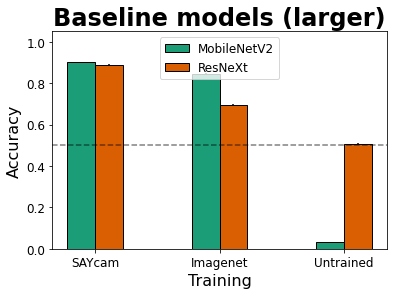

In [7]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], flip=None, dino=None),
    group_bars_by='training', 
    color_bars_by='model', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (6, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Baseline models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper center',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

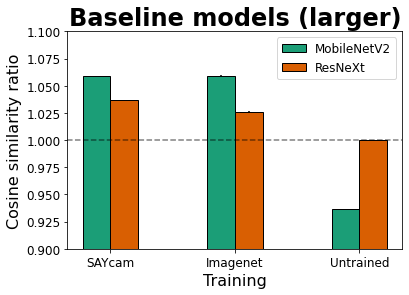

In [8]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], flip=None, dino=None),
    group_bars_by='training', 
    color_bars_by='model', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='cos_ratio',
    compute_std=True,
    # plot style arguments
    figsize = (6, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Baseline models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper right',
    ylim=(0.9, 1.1),
    y_chance=1.0,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )
    

   

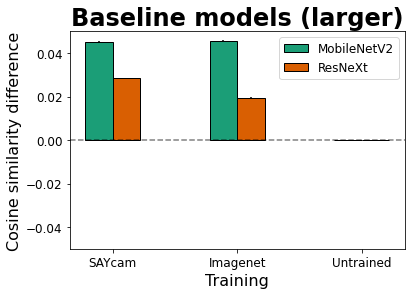

In [9]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], flip=None, dino=None),
    group_bars_by='training', 
    color_bars_by='model', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='cos_diff',
    compute_std=True,
    # plot style arguments
    figsize = (6, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Baseline models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper right',
    ylim=(-0.05, 0.05),
    y_chance=0,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )
    

   

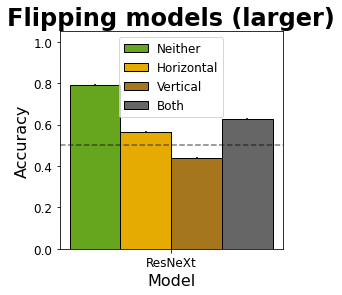

In [10]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='model', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (4, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Flipping models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper center',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

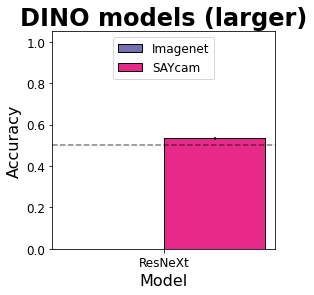

In [11]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO'),
    group_bars_by='model', 
    color_bars_by='dino', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (4, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'DINO models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper center',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

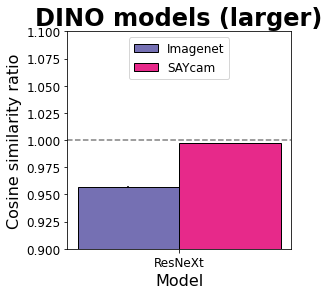

In [12]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO'),
    group_bars_by='model', 
    color_bars_by='dino', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='cos_ratio',
    compute_std=True,
    # plot style arguments
    figsize = (4, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'DINO models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper center',
    ylim=(0.9, 1.1),
    y_chance=1.0,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

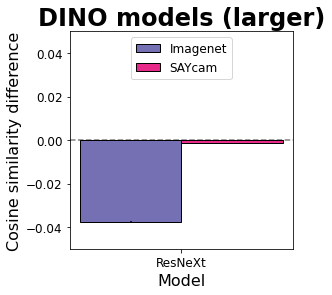

In [13]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO'),
    group_bars_by='model', 
    color_bars_by='dino', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='cos_diff',
    compute_std=True,
    # plot style arguments
    figsize = (4, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'DINO models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper center',
    ylim=(-0.05, 0.05),
    y_chance=0.0,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [14]:
filter_and_group(combined_df, dict(training='DINO'), ['model', 'dino']).correct.mean()

model    dino     
resnext  ImageNet     0.000000
         saycam(S)    0.532715
Name: correct, dtype: float64

In [15]:
combined_df[combined_df.training == 'DINO'][combined_df.dino == 'ImageNet']

/var/folders/h9/kzpqpksx6fq00v9d73x5j51c0000gn/T/ipykernel_8736/3096591689.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  combined_df[combined_df.training == 'DINO'][combined_df.dino == 'ImageNet']


,model,training,flip,dino,configuration_index,example_index,bowl_color,target_object,containment_high_containment_cos,containment_behind_cos,containment_support_cos,high_containment_behind_cos,high_containment_support_cos,behind_support_cos,correct,cos_ratio,cos_diff
90112,resnext,DINO,None,ImageNet,0,0,brown,BeachBall,0.790827,0.828744,0.830943,0.948535,0.945324,0.967396,False,0.951722,-0.040116
90113,resnext,DINO,None,ImageNet,0,1,brown,Knight,0.884048,0.877565,0.898226,0.957286,0.927321,0.949506,False,0.984215,-0.014178
90114,resnext,DINO,None,ImageNet,0,2,brown,Lego,0.807176,0.862019,0.840312,0.930387,0.904878,0.941243,False,0.936378,-0.054843
90115,resnext,DINO,None,ImageNet,0,3,brown,Pineapple,0.849684,0.867118,0.884284,0.958636,0.912403,0.945931,False,0.960872,-0.034600
90116,resnext,DINO,None,ImageNet,0,4,brown,Robot,0.851729,0.868783,0.868985,0.934821,0.905083,0.944743,False,0.980142,-0.017256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98299,resnext,DINO,None,ImageNet,1023,8187,green,Pineapple,0.836444,0.861583,0.873542,0.954927,0.905369,0.946470,False,0.957531,-0.037098
98300,resnext,DINO,None,ImageNet,1023,8188,green,Robot,0.839658,0.866353,0.863785,0.929928,0.903461,0.947949,False,0.969188,-0.026694
98301,resnext,DINO,None,ImageNet,1023,8189,green,RubberDuck,0.846208,0.879867,0.883563,0.945256,0.910593,0.961684,False,0.957722,-0.037355
98302,resnext,DINO,None,ImageNet,1023,8190,green,Teddy,0.824687,0.885994,0.863791,0.928199,0.881619,0.945410,False,0.930805,-0.061307


In [16]:
compare_df_group_and_filter(larger_df, smaller_df, 
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='bowl_color', 
    color_bars_by='flip', 
    relevant_fields=('containment_high_containment_cos', 'correct', 'cos_ratio'))

## First dataframe

### Mean:

containment_high_containment_cos   correct  cos_ratio
bowl_color flip                                                       
blue       h                             0.840466  0.500488   1.005216
           hv                            0.805180  0.625000   1.000891
           s                             0.819015  0.753906   1.015308
           v                             0.858123  0.500000   0.987854
brown      h                             0.835700  0.632812   1.009124
           hv                            0.820057  0.625488   1.014155
           s                             0.825545  0.880859   1.020043
           v                             0.856507  0.625000   0.997845
green      h                             0.832929  0.626465   1.011522
           hv                            0.813300  0.627441   1.011205
           s                             0.812053  0.639648   1.015221
           v                             0.857698  0.500000   0.993413
purple     h                             0.830540  0.500000   0.999201
           hv                            0.796853  0.625000   1.002824
           s                             0.820391  0.895996   1.024071
           v                             0.853659  0.125000   0.981370

### Std:

containment_high_containment_cos   correct  cos_ratio
bowl_color flip                                                       
blue       h                             0.031155  0.500122   0.041475
           hv                            0.069036  0.484241   0.044677
           s                             0.034022  0.430839   0.027941
           v                             0.084021  0.500122   0.036447
brown      h                             0.029655  0.482156   0.029433
           hv                            0.054840  0.484115   0.039090
           s                             0.035234  0.324033   0.028590
           v                             0.080130  0.484241   0.034285
green      h                             0.029442  0.483860   0.035679
           hv                            0.057167  0.483604   0.031894
           s                             0.038290  0.480220   0.030492
           v                             0.080506  0.500122   0.036634
purple     h                             0.034505  0.500122   0.044014
           hv                            0.071437  0.484241   0.043004
           s                             0.037119  0.305340   0.022270
           v                             0.083851  0.330800   0.030822

## Second dataframe

### Mean:

containment_high_containment_cos   correct  cos_ratio
bowl_color flip                                                       
blue       h                             0.842020  0.500000   1.005619
           hv                            0.806884  0.625000   1.001045
           s                             0.820361  0.750000   1.014975
           v                             0.860465  0.500000   0.988194
brown      h                             0.836742  0.628906   1.009288
           hv                            0.820614  0.625000   1.013416
           s                             0.826407  0.878906   1.020084
           v                             0.858700  0.625000   0.998462
green      h                             0.831230  0.625000   1.011225
           hv                            0.812148  0.628906   1.010877
           s                             0.812039  0.632812   1.014477
           v                             0.856072  0.500000   0.992811
purple     h                             0.830448  0.500000   0.999487
           hv                            0.796856  0.625000   1.002524
           s                             0.819202  0.894531   1.024240
           v                             0.853769  0.125000   0.981032

### Std:

containment_high_containment_cos   correct  cos_ratio
bowl_color flip                                                       
blue       h                             0.027844  0.500979   0.040996
           hv                            0.064707  0.485071   0.044394
           s                             0.031045  0.433861   0.028456
           v                             0.077672  0.500979   0.035706
brown      h                             0.029582  0.484044   0.028965
           hv                            0.054082  0.485071   0.040206
           s                             0.034859  0.326875   0.028541
           v                             0.076058  0.485071   0.032901
green      h                             0.033478  0.485071   0.036300
           hv                            0.059251  0.484044   0.032521
           s                             0.037405  0.482982   0.031275
           v                             0.084037  0.500979   0.037751
purple     h                             0.034823  0.500979   0.043778
           hv                            0.071715  0.485071   0.043756
           s                             0.039795  0.307758   0.021880
           v                             0.083686  0.331367   0.031853

containment_high_containment_cos   correct  cos_ratio
bowl_color flip                                                       
blue       h                            -0.001554  0.000488  -0.000403
           hv                           -0.001703  0.000000  -0.000154
           s                            -0.001345  0.003906   0.000333
           v                            -0.002342  0.000000  -0.000340
brown      h                            -0.001041  0.003906  -0.000164
           hv                           -0.000558  0.000488   0.000739
           s                            -0.000861  0.001953  -0.000041
           v                            -0.002193  0.000000  -0.000618
green      h                             0.001699  0.001465   0.000297
           hv                            0.001152 -0.001465   0.000328
           s                             0.000013  0.006836   0.000744
           v                             0.001626  0.000000   0.000601
purple     h                             0.000092  0.000000  -0.000285
           hv                           -0.000003  0.000000   0.000301
           s                             0.001189  0.001465  -0.000168
           v                            -0.000110  0.000000   0.000339

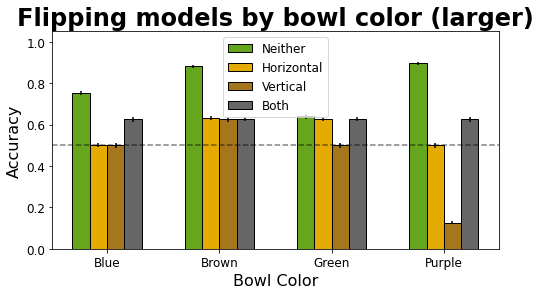

In [17]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='bowl_color', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (8, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Flipping models by bowl color{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper center',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

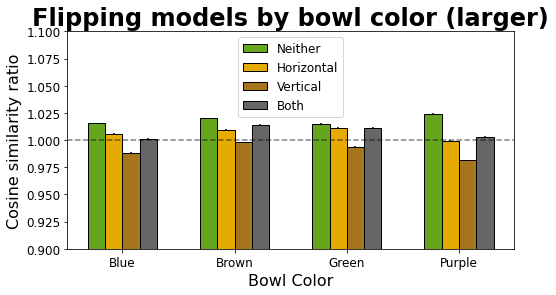

In [18]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='bowl_color', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='cos_ratio',
    compute_std=True,
    # plot style arguments
    figsize = (8, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Flipping models by bowl color{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper center',
    ylim=(0.9, 1.1),
    y_chance=1.0,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

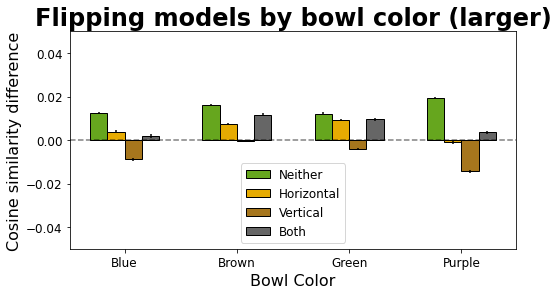

In [29]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='bowl_color', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='cos_diff',
    compute_std=True,
    # plot style arguments
    figsize = (8, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Flipping models by bowl color{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='lower center',
    ylim=(-0.05, 0.05),
    y_chance=0.0,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

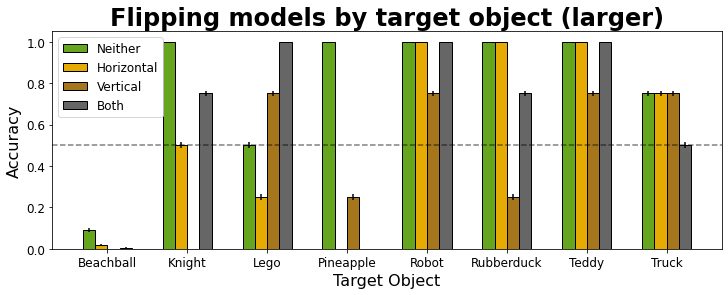

In [20]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='target_object', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (12, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Flipping models by target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper left',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

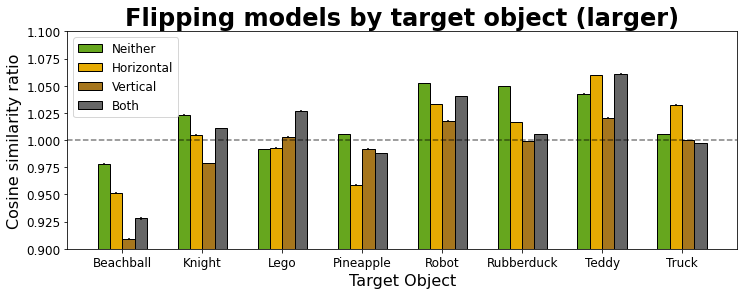

In [21]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='target_object', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='cos_ratio',
    compute_std=True,
    # plot style arguments
    figsize = (12, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Flipping models by target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper left',
    ylim=(0.9, 1.1),
    y_chance=1.0,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

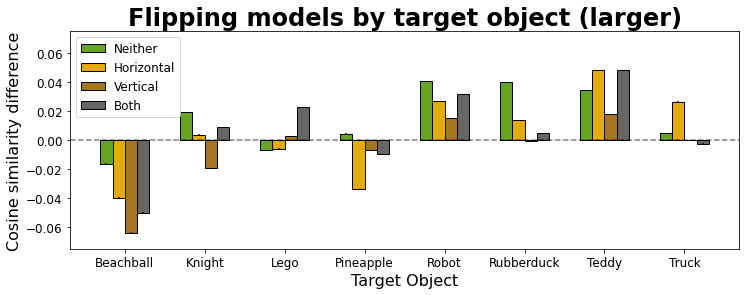

In [22]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='target_object', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='cos_diff',
    compute_std=True,
    # plot style arguments
    figsize = (12, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Flipping models by target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper left',
    ylim=(-0.075, 0.075),
    y_chance=0.0,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

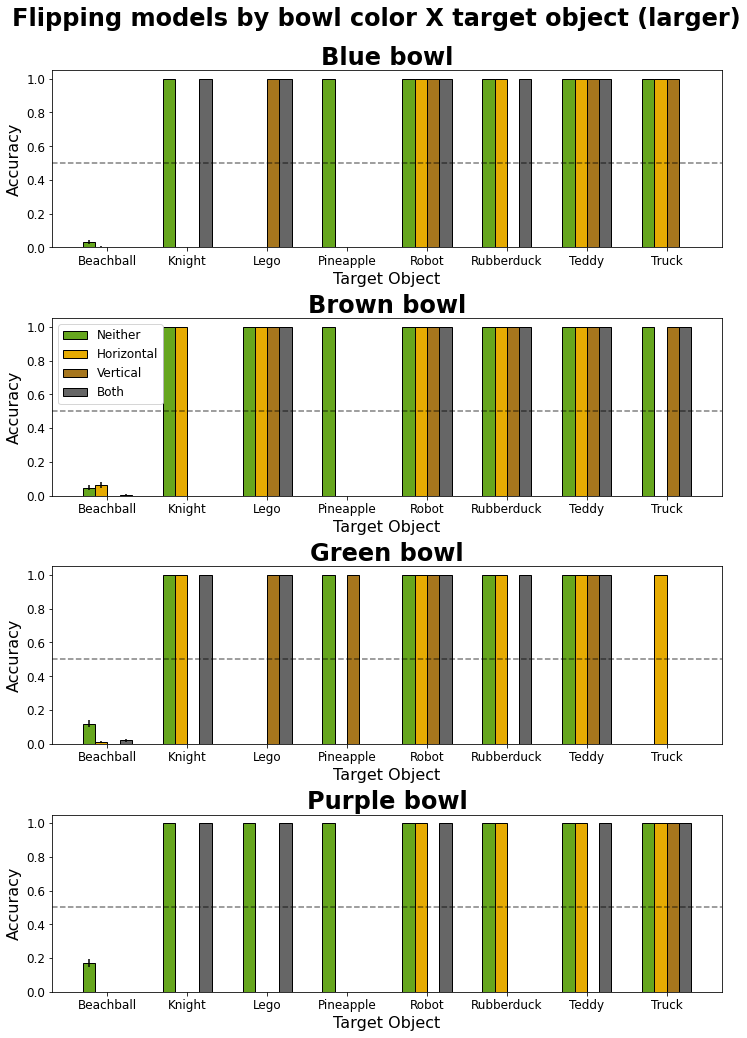

In [23]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='target_object', 
    color_bars_by='flip', 
    panel_by='bowl_color',
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (12, 16),
    layout = (4, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=['Blue bowl', 'Brown bowl', 'Green bowl', 'Purple bowl'],
    sup_title=f'Flipping models by bowl color X target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=1,
    legend_loc='upper left',
    subplot_adjust_params=dict(top=0.925, hspace=0.4),
    ylabel_per_ax=True,
    ylabel=['Accuracy'] * 4,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

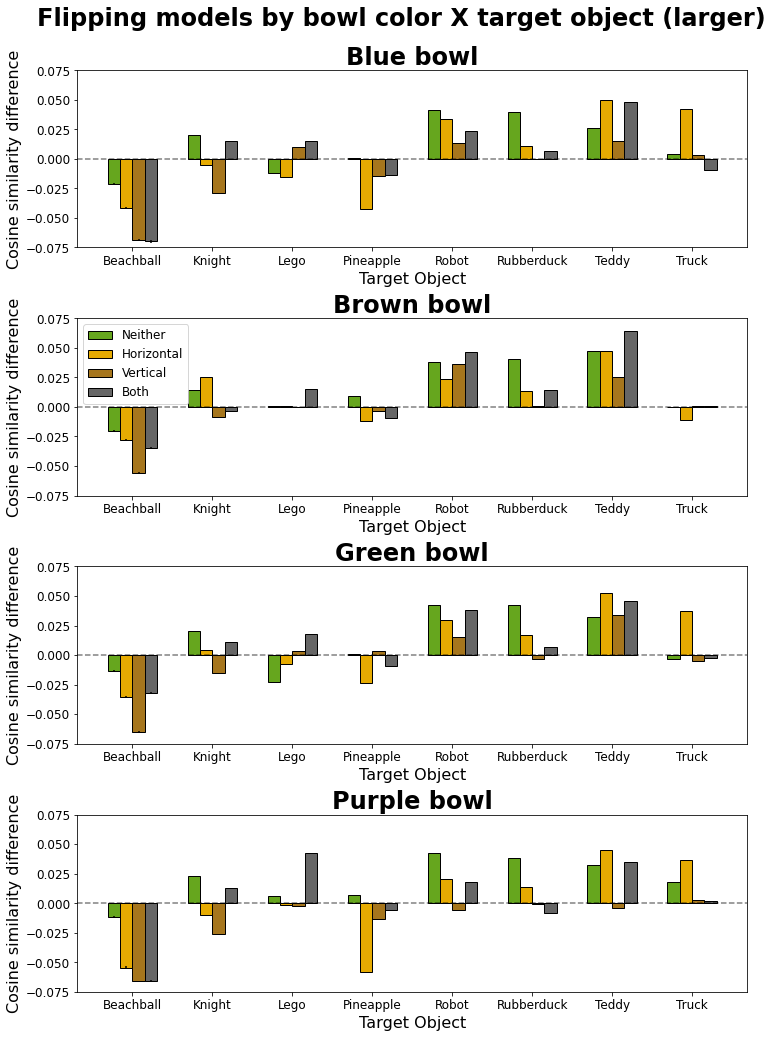

In [24]:
plot_field = 'cos_diff'

multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='target_object', 
    color_bars_by='flip', 
    panel_by='bowl_color',
    # hatch_bars_by='n_target_types',
    plot_field=plot_field,
    compute_std=True,
    # plot style arguments
    figsize = (12, 16),
    layout = (4, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=['Blue bowl', 'Brown bowl', 'Green bowl', 'Purple bowl'],
    sup_title=f'Flipping models by bowl color X target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=1,
    legend_loc='upper left',
    ylim=(-0.075, 0.075),
    y_chance=0.0,
    subplot_adjust_params=dict(top=0.925, hspace=0.4),
    ylabel_per_ax=True,
    ylabel=[DEFAULT_YALBELS[plot_field]] * 4,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

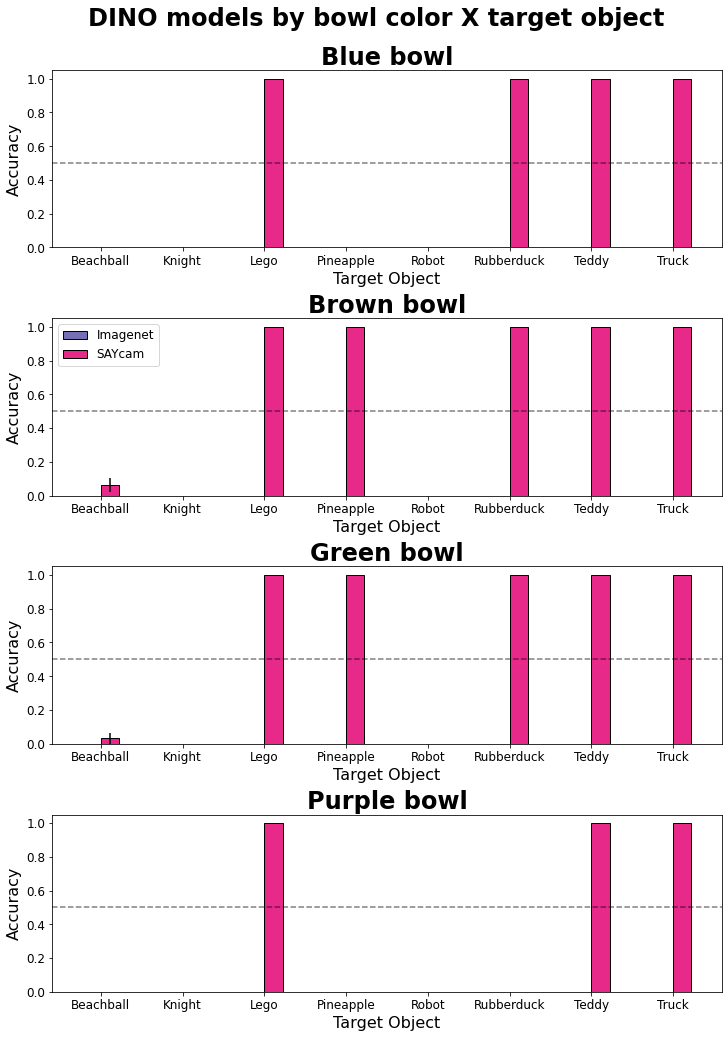

In [35]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO'),
    group_bars_by='target_object', 
    color_bars_by='dino', 
    panel_by='bowl_color',
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (12, 16),
    layout = (4, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=['Blue bowl', 'Brown bowl', 'Green bowl', 'Purple bowl'],
    sup_title=f'DINO models by bowl color X target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=1,
    legend_loc='upper left',
    subplot_adjust_params=dict(top=0.925, hspace=0.4),
    ylabel_per_ax=True,
    ylabel=['Accuracy'] * 4,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

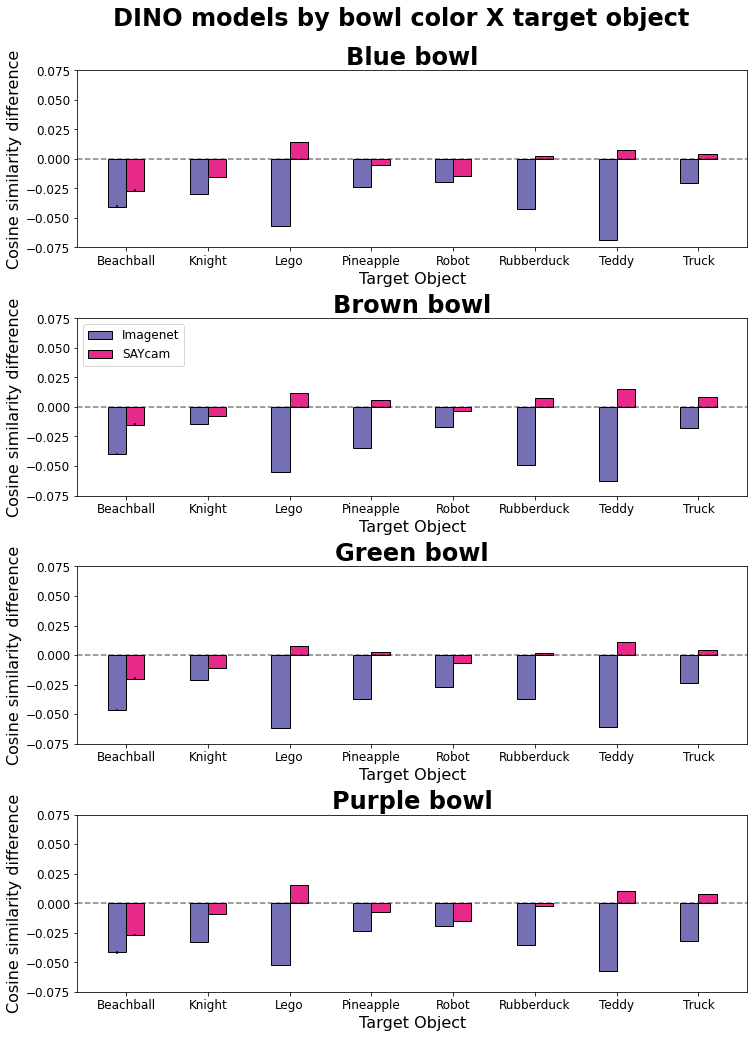

In [36]:
plot_field = 'cos_diff'

multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO'),
    group_bars_by='target_object', 
    color_bars_by='dino', 
    panel_by='bowl_color',
    # hatch_bars_by='n_target_types',
    plot_field=plot_field,
    compute_std=True,
    # plot style arguments
    figsize = (12, 16),
    layout = (4, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=['Blue bowl', 'Brown bowl', 'Green bowl', 'Purple bowl'],
    sup_title=f'DINO models by bowl color X target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=1,
    legend_loc='upper left',
    ylim=(-0.075, 0.075),
    y_chance=0.0,
    subplot_adjust_params=dict(top=0.925, hspace=0.4),
    ylabel_per_ax=True,
    ylabel=[DEFAULT_YALBELS[plot_field]] * 4,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [25]:
compare_df_group_and_filter(larger_df, smaller_df, 
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='target_object', 
    color_bars_by='flip', 
    panel_by='bowl_color',
    relevant_fields=('containment_high_containment_cos', 'correct', 'cos_ratio'))

## First dataframe

### Mean:

containment_high_containment_cos   correct  \
bowl_color target_object flip                                               
blue       BeachBall     h                             0.796876  0.003906   
                         hv                            0.637775  0.000000   
                         s                             0.752254  0.031250   
                         v                             0.644773  0.000000   
           Knight        h                             0.837306  0.000000   
...                                                         ...       ...   
purple     Teddy         v                             0.876196  0.000000   
           Truck         h                             0.855676  1.000000   
                         hv                            0.814631  1.000000   
                         s                             0.836417  1.000000   
                         v                             0.884191  1.000000   

                               cos_ratio  
bowl_color target_object flip             
blue       BeachBall     h      0.949800  
                         hv     0.900971  
                         s      0.972253  
                         v      0.902739  
           Knight        h      0.994028  
...                                  ...  
purple     Teddy         v      0.995787  
           Truck         h      1.044938  
                         hv     1.001874  
                         s      1.021430  
                         v      1.002648  

[128 rows x 3 columns]

### Std:

containment_high_containment_cos   correct  \
bowl_color target_object flip                                               
blue       BeachBall     h                             0.039254  0.062500   
                         hv                            0.056362  0.000000   
                         s                             0.048225  0.174333   
                         v                             0.064158  0.000000   
           Knight        h                             0.000003  0.000000   
...                                                         ...       ...   
purple     Teddy         v                             0.000000  0.000000   
           Truck         h                             0.000000  0.000000   
                         hv                            0.000000  0.000000   
                         s                             0.000000  0.000000   
                         v                             0.000000  0.000000   

                               cos_ratio  
bowl_color target_object flip             
blue       BeachBall     h      0.016630  
                         hv     0.020367  
                         s      0.014944  
                         v      0.019890  
           Knight        h      0.000003  
...                                  ...  
purple     Teddy         v      0.000000  
           Truck         h      0.000000  
                         hv     0.000000  
                         s      0.000000  
                         v      0.000000  

[128 rows x 3 columns]

## Second dataframe

### Mean:

containment_high_containment_cos  correct  \
bowl_color target_object flip                                              
blue       BeachBall     h                             0.809308      0.0   
                         hv                            0.651401      0.0   
                         s                             0.763017      0.0   
                         v                             0.663507      0.0   
           Knight        h                             0.837306      0.0   
...                                                         ...      ...   
purple     Teddy         v                             0.876196      0.0   
           Truck         h                             0.855676      1.0   
                         hv                            0.814631      1.0   
                         s                             0.836417      1.0   
                         v                             0.884191      1.0   

                               cos_ratio  
bowl_color target_object flip             
blue       BeachBall     h      0.953028  
                         hv     0.902206  
                         s      0.969590  
                         v      0.905457  
           Knight        h      0.994028  
...                                  ...  
purple     Teddy         v      0.995786  
           Truck         h      1.044938  
                         hv     1.001874  
                         s      1.021430  
                         v      1.002648  

[128 rows x 3 columns]

### Std:

containment_high_containment_cos  correct  \
bowl_color target_object flip                                              
blue       BeachBall     h                         3.048529e-02      0.0   
                         hv                        5.395010e-02      0.0   
                         s                         4.630692e-02      0.0   
                         v                         5.936658e-02      0.0   
           Knight        h                         3.792272e-07      0.0   
...                                                         ...      ...   
purple     Teddy         v                         2.001975e-07      0.0   
           Truck         h                         0.000000e+00      0.0   
                         hv                        0.000000e+00      0.0   
                         s                         0.000000e+00      0.0   
                         v                         0.000000e+00      0.0   

                                  cos_ratio  
bowl_color target_object flip                
blue       BeachBall     h     1.646839e-02  
                         hv    2.039135e-02  
                         s     1.427433e-02  
                         v     2.000884e-02  
           Knight        h     4.502086e-07  
...                                     ...  
purple     Teddy         v     1.440514e-07  
           Truck         h     0.000000e+00  
                         hv    0.000000e+00  
                         s     0.000000e+00  
                         v     0.000000e+00  

[128 rows x 3 columns]

containment_high_containment_cos   correct  \
bowl_color target_object flip                                               
blue       BeachBall     h                        -1.243213e-02  0.003906   
                         hv                       -1.362604e-02  0.000000   
                         s                        -1.076312e-02  0.031250   
                         v                        -1.873410e-02  0.000000   
           Knight        h                         8.265488e-08  0.000000   
...                                                         ...       ...   
purple     Teddy         v                         3.539026e-08  0.000000   
           Truck         h                         0.000000e+00  0.000000   
                         hv                        0.000000e+00  0.000000   
                         s                         0.000000e+00  0.000000   
                         v                         0.000000e+00  0.000000   

                                  cos_ratio  
bowl_color target_object flip                
blue       BeachBall     h    -3.227888e-03  
                         hv   -1.234483e-03  
                         s     2.662500e-03  
                         v    -2.717596e-03  
           Knight        h     9.812570e-08  
...                                     ...  
purple     Teddy         v     2.546494e-08  
           Truck         h     0.000000e+00  
                         hv    0.000000e+00  
                         s     0.000000e+00  
                         v     0.000000e+00  

[128 rows x 3 columns]

In [26]:
for df in (smaller_df, larger_df):
    for bowl_color in df.bowl_color.unique():
        print(bowl_color, df[df.bowl_color == bowl_color].target_object.unique())

brown ['BeachBall' 'Knight' 'Lego' 'Pineapple' 'Robot' 'RubberDuck' 'Teddy'
 'Truck']
blue ['BeachBall' 'Knight' 'Lego' 'Pineapple' 'Robot' 'RubberDuck' 'Teddy'
 'Truck']
purple ['BeachBall' 'Knight' 'Lego' 'Pineapple' 'Robot' 'RubberDuck' 'Teddy'
 'Truck']
green ['BeachBall' 'Knight' 'Lego' 'Pineapple' 'Robot' 'RubberDuck' 'Teddy'
 'Truck']
brown ['BeachBall' 'Knight' 'Lego' 'Pineapple' 'Robot' 'RubberDuck' 'Teddy'
 'Truck']
blue ['BeachBall' 'Knight' 'Lego' 'Pineapple' 'Robot' 'RubberDuck' 'Teddy'
 'Truck']
purple ['BeachBall' 'Knight' 'Lego' 'Pineapple' 'Robot' 'RubberDuck' 'Teddy'
 'Truck']
green ['BeachBall' 'Knight' 'Lego' 'Pineapple' 'Robot' 'RubberDuck' 'Teddy'
 'Truck']


In [27]:
for df in (smaller_df, larger_df):
    for bowl_color in df.bowl_color.unique():
        print(bowl_color, df[df.bowl_color == bowl_color].example_index.unique())

brown [  0   1   2   3   4   5   6   7  32  33  34  35  36  37  38  39  64  65
  66  67  68  69  70  71  96  97  98  99 100 101 102 103 128 129 130 131
 132 133 134 135 160 161 162 163 164 165 166 167 192 193 194 195 196 197
 198 199 224 225 226 227 228 229 230 231 256 257 258 259 260 261 262 263
 288 289 290 291 292 293 294 295 320 321 322 323 324 325 326 327 352 353
 354 355 356 357 358 359 384 385 386 387 388 389 390 391 416 417 418 419
 420 421 422 423 448 449 450 451 452 453 454 455 480 481 482 483 484 485
 486 487 512 513 514 515 516 517 518 519 544 545 546 547 548 549 550 551
 576 577 578 579 580 581 582 583 608 609 610 611 612 613 614 615 640 641
 642 643 644 645 646 647 672 673 674 675 676 677 678 679 704 705 706 707
 708 709 710 711 736 737 738 739 740 741 742 743 768 769 770 771 772 773
 774 775 800 801 802 803 804 805 806 807 832 833 834 835 836 837 838 839
 864 865 866 867 868 869 870 871 896 897 898 899 900 901 902 903 928 929
 930 931 932 933 934 935 960 961 962 963 964 

In [28]:
for df in (smaller_df, larger_df):
    for target_object in df.target_object.unique():
        print(target_object, df[df.target_object == target_object].example_index.unique())

BeachBall [   0    8   16   24   32   40   48   56   64   72   80   88   96  104
  112  120  128  136  144  152  160  168  176  184  192  200  208  216
  224  232  240  248  256  264  272  280  288  296  304  312  320  328
  336  344  352  360  368  376  384  392  400  408  416  424  432  440
  448  456  464  472  480  488  496  504  512  520  528  536  544  552
  560  568  576  584  592  600  608  616  624  632  640  648  656  664
  672  680  688  696  704  712  720  728  736  744  752  760  768  776
  784  792  800  808  816  824  832  840  848  856  864  872  880  888
  896  904  912  920  928  936  944  952  960  968  976  984  992 1000
 1008 1016]
Knight [   1    9   17   25   33   41   49   57   65   73   81   89   97  105
  113  121  129  137  145  153  161  169  177  185  193  201  209  217
  225  233  241  249  257  265  273  281  289  297  305  313  321  329
  337  345  353  361  369  377  385  393  401  409  417  425  433  441
  449  457  465  473  481  489  497  505  513  5